### Install

In [1]:
!pip install -U --pre tensorflow=="2.*"
!pip install pycocotools

Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [2]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2662, done.
remote: Counting objects: 100% (2662/2662), done.
remote: Compressing objects: 100% (2328/2328), done.
remote: Total 2662 (delta 527), reused 1323 (delta 300), pack-reused 0
Receiving objects: 100% (2662/2662), 32.17 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (527/527), done.


In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1113489 sha256=a3c7954ce70e332447dc6f33039247a32dcdf93964ddc3e90a839a0dff678301
  Stored in directory: /tmp/pip-ephem-wheel-cache-dvyq5_6t/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


### Imports

In [0]:
import tensorflow as tf
import numpy as np

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import math
from PIL import Image, ImageDraw
from itertools import compress, permutations

# Model preparation 

In [5]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76537856/76534733 [==============================] - 2s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Detection

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
  return output_dict

In [0]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=0.0)

  display(Image.fromarray(image_np))
  return output_dict

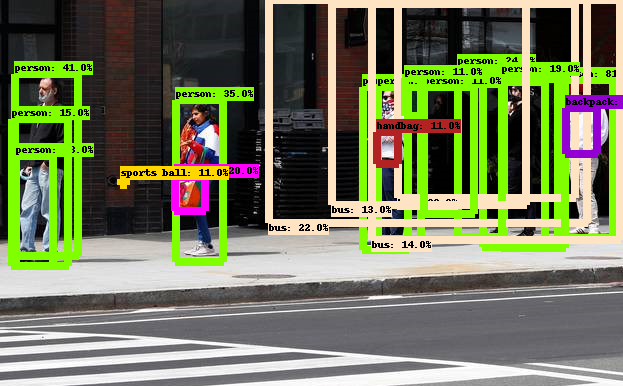

{'detection_classes': array([ 1,  1,  1,  1,  1,  1,  1,  6,  6, 34,  1,  1,  1,  6,  6,  1, 37,
        1, 31, 27,  1, 31, 32, 41,  6, 72,  1,  1, 31, 32,  1,  1,  6,  1,
       31, 41,  1,  1,  6,  1, 77,  1,  6,  1, 28, 41,  1,  1,  1,  6, 31,
       27,  1,  1,  1,  1, 72,  1,  1,  6, 72,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, 27,  1,  6,  1,  1,  1,  1,  1, 28, 31,  1,
       72,  1,  1,  1,  1,  1, 35, 31,  1,  6,  6,  1,  1,  6,  1]), 'detection_boxes': array([[2.08880886e-01, 8.94316375e-01, 6.14680827e-01, 9.83991444e-01],
       [2.13738754e-01, 7.73688734e-01, 6.38925612e-01, 8.75929296e-01],
       [2.27250323e-01, 5.81192493e-01, 6.47587001e-01, 6.56482697e-01],
       [1.94268763e-01, 2.25679725e-02, 6.61238074e-01, 1.26642555e-01],
       [2.60696739e-01, 2.82485336e-01, 6.76393509e-01, 3.59005898e-01],
       [1.75948560e-01, 7.34168053e-01, 6.12604916e-01, 8.10147643e-01],
       [2.26474434e-01, 6.05419397e-01, 6.18603230e-01, 6.77157760e-01],
    

In [42]:
res = show_inference(detection_model, 'c.jpeg')
print(res)

[0.1152670660983591, 0.3213406891916103, 0.8646961802449364, 0.6210080508092573, 0.2062695698873042, 0.7502050972534317, 0.5058278764405262, 0.5443181488116354, 0.29971266964390453, 0.24949756868574652]


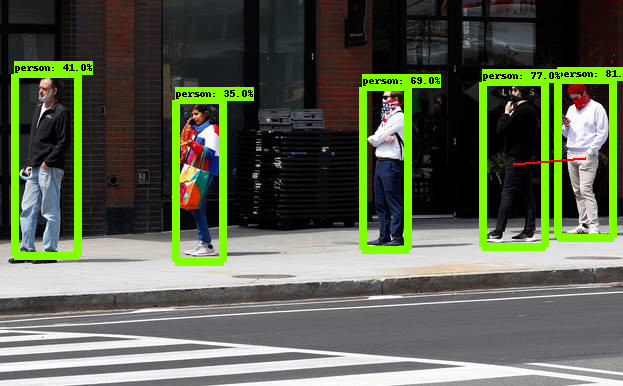

In [36]:
def calculate_centroid(bounding_box):
  return (((bounding_box[3]-bounding_box[1])/2)+bounding_box[1],((bounding_box[2]-bounding_box[0])/2)+bounding_box[0])


def calculate_permutations(detection_centroids):
  perms = []
  for current_permutation in permutations(detection_centroids, 2):
    if current_permutation[::-1] not in perms:
        perms.append(current_permutation)
  return perms

def calculate_centroid_distances(centroid1,centroid2):
  return  math.sqrt((centroid2[0]-centroid1[0])**2 + (centroid2[1]-centroid1[1])**2)

def calculate_all_distances(centroids): 
  distances = []
  for centroid in centroids:
    distances.append(calculate_centroid_distances(centroid[0],centroid[1]))
  return distances

def normalize_centroids(centroids,im_width,im_height):
  newCentroids = []
  for centroid in centroids:
    newCentroids.append((centroid[0]*im_width,centroid[1]*im_height))
  return newCentroids


def show_inference_calculating_distance(model, image_path):
  distance_treshold = 0.2
  person_class = 1
  score_treshold = 0.3
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=score_treshold)

  #Filter persons and boxes with a score higher than 50%
  boolPersons = output_dict['detection_classes'] == person_class
  boolScores = output_dict['detection_scores'] > score_treshold
  boolCombined = np.logical_and(boolPersons,boolScores)

  output_dict['detection_scores'] = output_dict['detection_scores'][boolCombined]
  output_dict['detection_classes'] = output_dict['detection_classes'][boolCombined]
  output_dict['detection_boxes'] = output_dict['detection_boxes'][boolCombined]
  output_dict['detection_centroids'] = [calculate_centroid(x) for x in output_dict['detection_boxes']]
  
  #Get image width and size for further centroid normalization 
  im = Image.fromarray(image_np)
  im_width, im_height = im.size

  #Calculate permutations and distances
  output_dict['detection_permutations'] = calculate_permutations(output_dict['detection_centroids'])
  output_dict['detection_centroids_distances'] = calculate_all_distances(output_dict['detection_permutations'])
  
  #Filter permutations based on a distance treshold
  boolDistances = np.array(output_dict['detection_centroids_distances']) < distance_treshold
  output_dict['detection_centroids'] = normalize_centroids(output_dict['detection_centroids'],im_width,im_height)  
  output_dict['detection_permutations'] = calculate_permutations(output_dict['detection_centroids'])
  output_dict['detection_permutations'] = list(compress(output_dict['detection_permutations'], boolDistances))

  #Draw lines
  draw = ImageDraw.Draw(im)
  for centroid in output_dict['detection_permutations']: 
    draw.line((centroid[0],centroid[1]), fill=255, width=3)
  
  print(output_dict['detection_centroids_distances'])
  display(im)

show_inference_calculating_distance(detection_model, 'sample_image.jpeg')